In [1]:
import pickle
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error


In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")


mlflow.set_experiment("nyc-taxi-experinment")




<Experiment: artifact_location='/home/akogo/Desktop/mlops-rgt/003-training/experinment-Tracking/mlruns/1', creation_time=1730743850305, experiment_id='1', last_update_time=1730743850305, lifecycle_stage='active', name='nyc-taxi-experinment', tags={}>

In [5]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.1)


NameError: name 'experiment' is not defined

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# List experiments to confirm the creation
experiments = mlflow.search_experiments()
print("Experiments:", [exp.name for exp in experiments])


Experiments: ['nyc-taxi-experinment', 'Default']


In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:


train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)



9.838799799886681

/tmp/ipykernel_4832/437147669.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_4832/437147669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


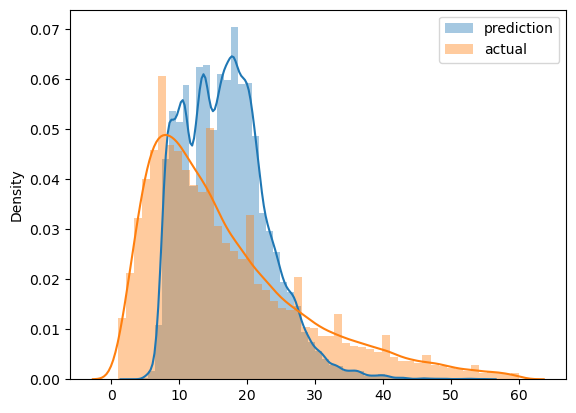

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:


df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')



In [12]:


len(df_train), len(df_val)


(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715206128955

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)


In [18]:
with mlflow.start_run():
    mlflow.set_tag("developer","kennedy")

    mlflow.log_param('train-data-path','./data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path','./data/green_tripdata_2021-02.parquet')

    alpha = 0.1

    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse =root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rsme",rmse)

In [19]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK , Trials

from hyperopt.pyll import scope

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [36]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [37]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/akogo/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:05:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20160                           
[1]	validation-rmse:7.08285                           
[2]	validation-rmse:6.78368                           
[3]	validation-rmse:6.68676                           
[4]	validation-rmse:6.64983                           
[5]	validation-rmse:6.63104                           
[6]	validation-rmse:6.62402                           
[7]	validation-rmse:6.61769                           
[8]	validation-rmse:6.60910                           
[9]	validation-rmse:6.60417                           
[10]	validation-rmse:6.59757                          
[11]	validation-rmse:6.59471                          
[12]	validation-rmse:6.59370                          
[13]	validation-rmse:6.58982                          
[14]	validation-rmse:6.58665                          
[15]	validation-rmse:6.58504                          
[16]	validation-rmse:6.58171                          
[17]	validation-rmse:6.57671                          
[18]	valid

/home/akogo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/akogo/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:07:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.39697                                                       
[1]	validation-rmse:6.67589                                                       
[2]	validation-rmse:6.53995                                                       
[3]	validation-rmse:6.49444                                                       
[4]	validation-rmse:6.47652                                                       
[5]	validation-rmse:6.46751                                                       
[6]	validation-rmse:6.45810                                                       
[7]	validation-rmse:6.44991                                                       
[8]	validation-rmse:6.44495                                                       
[9]	validation-rmse:6.43916                                                       
[10]	validation-rmse:6.43505                                                      
[11]	validation-rmse:6.43268                                                      
[12]

/home/akogo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/akogo/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:08:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53611                                                     
[1]	validation-rmse:10.93135                                                     
[2]	validation-rmse:10.39239                                                     
[3]	validation-rmse:9.91353                                                      
[4]	validation-rmse:9.48840                                                      
[5]	validation-rmse:9.11348                                                      
[6]	validation-rmse:8.78166                                                      
[7]	validation-rmse:8.49041                                                      
[8]	validation-rmse:8.23470                                                      
[9]	validation-rmse:8.01079                                                      
  4%|▍         | 2/50 [04:02<1:37:06, 121.39s/trial, best loss: 6.315077194480435]


KeyboardInterrupt: 